In [1]:
# (c) 2021, Christoph Schmidt-Hieber
# See LICENSE

import matplotlib
# %matplotlib widget
%matplotlib inline

import matplotlib.pyplot as plt

import os
import copy
import datetime
import numpy as np
from scipy.stats import pearsonr

import zwiftpower

## URLs of some (legit) .fit files
Simultaneously recorded with Zwift/Kickr Core ('zwift') and Garmin Edge 530/Garmin Vector 3 ('extern')

From https://zwiftpower.com/analysis.php?set_id=76982

In [2]:
url_legit = {
    'zwift': 
        "https://s3-fit-prd-uswest2-zwift.s3.amazonaws.com/prod/1101955/ba0d2670-693460566163739712",
    'extern':
        "https://zwift-zwiftpower-prd-artifacts.s3.amazonaws.com/user/prd-dmz/analysis/analysis_1101955_136049.fit"
}

## Download files, parse & plot power data

In [3]:
filenames = {}
timeseries = {}
sources = ['zwift', 'extern']
for source in sources:
    print("Downloading...")
    filenames[source] = zwiftpower.get_fitfile(url_legit[source])
    print("Parsing...")
    timeseries[source], dt = zwiftpower.parse_fitfile(filenames[source], verbose=False)

Downloading...
Parsing...
Downloading...
Parsing...


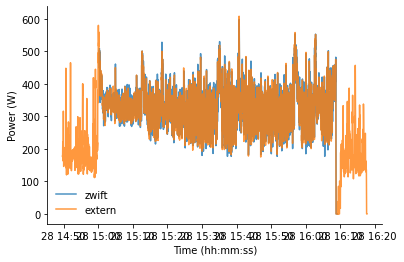

In [4]:
fig = plt.figure()
ax0 = fig.add_subplot()
for source in sources:
    ax0.plot(timeseries[source], label=source, alpha=0.8)
zwiftpower.prettify_plot(ax0)
ax0.set_xlabel('Time (hh:mm:ss)')
ax0.set_ylabel('Power (W)')
ax0.legend(frameon=False)

## Align recordings
We account both for different start times and for time offsets between devices
by finding the time lag that produces the largest correlation

In [5]:
net_lag, recording_lag, lags = zwiftpower.align_fit_timeseries(
    timeseries['zwift'], timeseries['extern'], dt=dt)
print(
    "Difference in recording start time: {0:.3f}s".format(recording_lag))
print(
    "Offset between devices: {0:.3f}s".format(net_lag))
timeseries['extern'].index += datetime.timedelta(seconds=net_lag)

residuals = timeseries['zwift']-timeseries['extern']

Difference in recording start time: 640.000s
Offset between devices: 1.100s


Text(0, 0.5, '$\\Delta$ Power (W)')

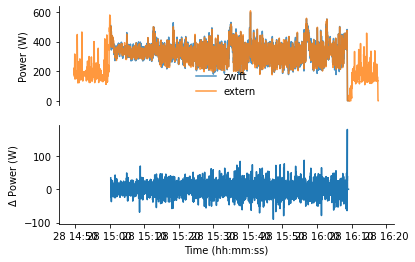

In [6]:
fig = plt.figure()
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212, sharex=ax0)
for source in sources:
    ax0.plot(timeseries[source], label=source, alpha=0.8)
ax1.plot(residuals)
for ax in [ax0, ax1]:
    zwiftpower.prettify_plot(ax)
ax0.legend(frameon=False)
ax0.spines['bottom'].set_visible(False)
ax0.xaxis.set_visible(False)
ax0.set_ylabel("Power (W)")
ax1.set_xlabel("Time (hh:mm:ss)")
ax1.set_ylabel(r"$\Delta$ Power (W)")

## Use only the part of the recordings that is common to both sources

In [7]:
tstart = np.max((timeseries['zwift'].index[0], timeseries['extern'].index[0]))
tend = np.min((timeseries['zwift'].index[-1], timeseries['extern'].index[-1]))
timeseries_cut = {
    source: timeseries[source][0][
        (timeseries[source].index >= tstart) & (timeseries[source].index <= tend)]
    for source in sources
}


## Compare power data from Zwift and external source

Correlation coefficient: 0.9735


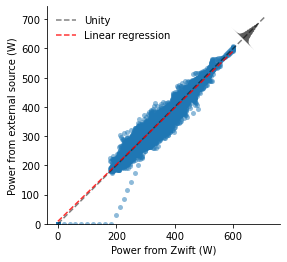

In [8]:
fig = plt.figure()
ax, histo, bins = zwiftpower.plot_unity_residuals(
    timeseries_cut['zwift'], timeseries_cut['extern'], fig, ratio=8.0, bins=100)
zwiftpower.prettify_plot(ax)
ax.set_xlabel('Power from Zwift (W)')
ax.set_ylabel('Power from external source (W)')
r, p = pearsonr(timeseries_cut['zwift'], timeseries_cut['extern'])
print("Correlation coefficient: {0:.4f}".format(r))

## Plot residuals, fit with normal distribution

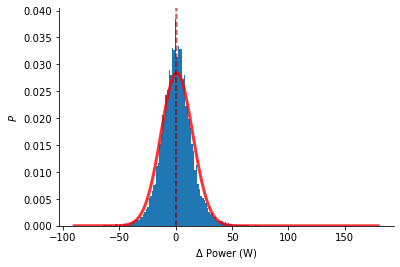

In [9]:
zwiftpower.plot_residual_distribution(timeseries_cut['zwift'], timeseries_cut['extern'])

## Plot cross correlation to account for time lags between recordings

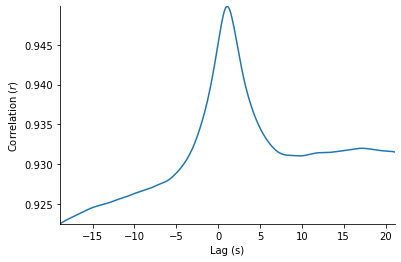

In [10]:
xcorr = zwiftpower.xcorr(timeseries['zwift'][0], timeseries['extern'][0])
period = 20.0
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(lags+recording_lag, xcorr)
peak = np.argmax(xcorr)
ymin = np.min(xcorr[
    (lags+recording_lag >= (lags+recording_lag)[peak]-period) &
    (lags+recording_lag < (lags+recording_lag)[peak]+period)
])
ymax = np.max(xcorr[
    (lags+recording_lag >= (lags+recording_lag)[peak]-period) &
    (lags+recording_lag < (lags+recording_lag)[peak]+period)
])
ax.set_xlim(
    (lags+recording_lag)[peak]-period,
    (lags+recording_lag)[peak]+period)
ax.set_ylim(ymin, ymax)
ax.set_ylabel(r"Correlation ($r$)")
ax.set_xlabel("Lag (s)")
zwiftpower.prettify_plot(ax)

## Print out some minimal stats

In [11]:
zwiftpower.summarize_stats(timeseries_cut['zwift'], timeseries_cut['extern'], sources)

Mean power (zwift): 325.38W
Mean power (extern): 324.45W
Mean residual ("offset"): 0.92W
Mean absolute residual ("precision"): 10.42W
Mean absolute residual after accounting for offset("precision"): 10.40W
Mean relative residual after accounting for offset ("precision"): 3.20%
Residual variance: 197.63W^2


## Simple fake data

In [12]:
sources = ['zwift', 'fake']
timeseries['fake'] = copy.deepcopy(timeseries['zwift'])
timeseries['fake'][0] += 5.0 + np.random.normal(0, np.sqrt(197.63), timeseries['fake'][0].shape)

Difference in recording start time: 0.000s
Offset between devices: 0.000s
Correlation coefficient: 0.9746
Mean power (zwift): 325.38W
Mean power (fake): 330.34W
Mean residual ("offset"): -4.97W
Mean absolute residual ("precision"): 11.90W
Mean absolute residual after accounting for offset("precision"): 11.19W
Mean relative residual after accounting for offset ("precision"): 3.41%
Residual variance: 196.00W^2


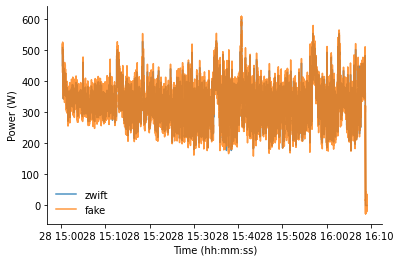

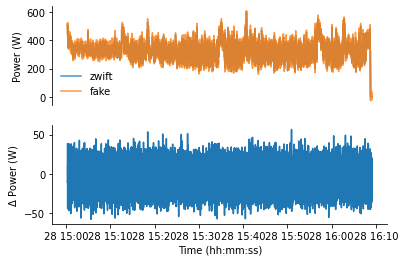

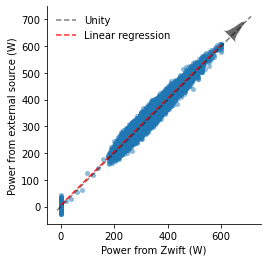

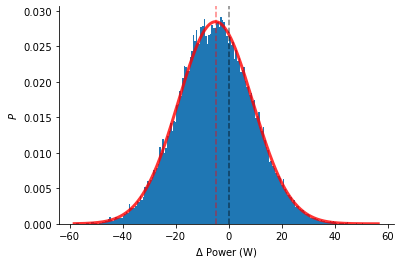

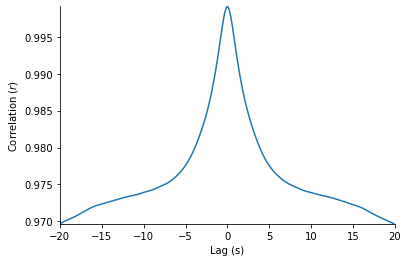

In [13]:
fig = plt.figure()
ax0 = fig.add_subplot()
for source in sources:
    ax0.plot(timeseries[source], label=source, alpha=0.8)
zwiftpower.prettify_plot(ax0)
ax0.set_xlabel('Time (hh:mm:ss)')
ax0.set_ylabel('Power (W)')
ax0.legend(frameon=False)
net_lag, recording_lag, lags = zwiftpower.align_fit_timeseries(
    timeseries['zwift'], timeseries['fake'], dt=dt)
print(
    "Difference in recording start time: {0:.3f}s".format(recording_lag))
print(
    "Offset between devices: {0:.3f}s".format(net_lag))
timeseries['fake'].index += datetime.timedelta(seconds=net_lag)
residuals = timeseries['zwift']-timeseries['fake']
fig = plt.figure()
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212, sharex=ax0)
for source in sources:
    ax0.plot(timeseries[source], label=source, alpha=0.8)
ax1.plot(residuals)
for ax in [ax0, ax1]:
    zwiftpower.prettify_plot(ax)
ax0.legend(frameon=False)
ax0.spines['bottom'].set_visible(False)
ax0.xaxis.set_visible(False)
ax0.set_ylabel("Power (W)")
ax1.set_xlabel("Time (hh:mm:ss)")
ax1.set_ylabel(r"$\Delta$ Power (W)")
tstart = np.max((timeseries['zwift'].index[0], timeseries['fake'].index[0]))
tend = np.min((timeseries['zwift'].index[-1], timeseries['fake'].index[-1]))
timeseries_cut = {
    source: timeseries[source][0][
        (timeseries[source].index >= tstart) & (timeseries[source].index <= tend)]
    for source in sources
}
fig = plt.figure()
ax, histo, bins = zwiftpower.plot_unity_residuals(
    timeseries_cut['zwift'], timeseries_cut['fake'], fig, ratio=8.0, bins=100)
zwiftpower.prettify_plot(ax)
ax.set_xlabel('Power from Zwift (W)')
ax.set_ylabel('Power from external source (W)')
r, p = pearsonr(timeseries_cut['zwift'], timeseries_cut['fake'])
print("Correlation coefficient: {0:.4f}".format(r))
zwiftpower.plot_residual_distribution(timeseries_cut['zwift'], timeseries_cut['fake'])
xcorr = zwiftpower.xcorr(timeseries['zwift'][0], timeseries['fake'][0])
period = 20.0
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(lags+recording_lag, xcorr)
peak = np.argmax(xcorr)
ymin = np.min(xcorr[
    (lags+recording_lag >= (lags+recording_lag)[peak]-period) &
    (lags+recording_lag < (lags+recording_lag)[peak]+period)
])
ymax = np.max(xcorr[
    (lags+recording_lag >= (lags+recording_lag)[peak]-period) &
    (lags+recording_lag < (lags+recording_lag)[peak]+period)
])
ax.set_xlim(
    (lags+recording_lag)[peak]-period,
    (lags+recording_lag)[peak]+period)
ax.set_ylim(ymin, ymax)
ax.set_ylabel(r"Correlation ($r$)")
ax.set_xlabel("Lag (s)")
zwiftpower.prettify_plot(ax)
zwiftpower.summarize_stats(timeseries_cut['zwift'], timeseries_cut['fake'], sources)
